In [3]:
import numpy as np
import matplotlib.pyplot as plt
import import_ipynb
import pandas as pd
import bioread
from scipy.fft import fft, fftfreq
from scipy import signal
from scipy.signal import find_peaks

In [4]:
def FIRrespt(ninput,xinput,nh,h):
    Nx=len(xinput);Nh=len(h);conv=np.convolve(xinput,h);n0=ninput[0]+nh[0];Nconv=Nx+Nh-1;nconv=np.arange(n0,n0 + Nconv);
    R = np.vstack((nconv,conv)).T
    return R   

In [5]:
def FIRrespf(w,h):
    Nh=len(h); H = 0
    for i in np.arange(Nh):
        H = H + h[i]*np.exp(-1j*w*i)
    R = np.vstack((w,abs(H),np.angle(H))).T
    return R 

In [6]:
def IIRrespt(xinput,c,d):
    N1 = len(xinput) # 
    nx = np.arange(-(len(c)-1),N1)
    x = xinput
    for k in np.arange(len(c)-1):
        x = np.insert(x,0,0)
    ny = np.arange(-(len(d)-1),N1)
    y = np.arange(0,len(ny),dtype=np.float64)
    for k in np.arange(len(d)-1):
        y[k] = 0
    for i in np.arange(len(d)-1,len(y)):
        z = 0
        for j in np.arange(1,len(d)):
            z = z - d[j]*y[i-j] + c[j]*x[i-j]
        y[i] = (z + c[0]* x[i])/d[0]
    R = np.vstack((ny,y)).T
    return R

In [7]:
def IIRrespf(w,c,d):
    Nc=len(c); Nd=len(d); Hnum = 0; Hden = 0
    for i in np.arange(Nc):
        Hnum = Hnum + c[i]*np.exp(-1j*w*i)
    for i in np.arange(Nd):
        Hden = Hden + d[i]*np.exp(-1j*w*i)
    H = np.divide(Hnum,Hden)
    R = np.vstack((w,abs(H),np.angle(H))).T
    return R

In [16]:
def FPM(nombreArchivo):
    # Leer el archivo de datos
    señal = np.loadtxt(nombreArchivo)
    N = len(señal); n = np.arange(N) 
    


    # Elimino tendencia -----------------------------------------------------------------------------
    A3 = np.arange(0,N,250) #arreglo
    B3 = tuple(A3) #tupla
    señal_sin_tendencia = signal.detrend(señal,bp=A3)
    #------------------------------------------------------------------------------------------------



    M = np.arange (2,6,1) #vector de ordenes de los FPM
    k = np.arange (0,30,dtype=np.float64)

    resp = np.empty ((N,len(M)))

    for i,N1 in enumerate (M):
        FPM = np.piecewise (k,(0<=k)&(k<=N1-1),[1/N1,0])
        resp[:,i] = np.convolve (señal_sin_tendencia,FPM,"same")


    peaks_max = find_peaks (señal_sin_tendencia,distance=150)[0]
    peaks_min = find_peaks (-señal_sin_tendencia,distance=150)[0]
    
    A_max_signal = np.mean (señal_sin_tendencia[peaks_max])
    A_min_signal = np.mean (señal_sin_tendencia[peaks_min])

    aux_max = np.zeros ((len(M),len(peaks_max)))
    aux_min = np.zeros ((len(M),len(peaks_min))) 

    for i in range  (len(M)):
        peaks2_max = find_peaks (resp[:,i],distance=150)[0]
        peaks2_min = find_peaks (-resp[:,i],distance=150)[0]
        aux_max [i,:] = resp [peaks2_max,i]
        aux_min [i,:] = resp [peaks2_min,i]
    A_max = np.mean (aux_max,axis=1) ; A_min = np.mean (aux_min,axis=1)
    A_signal = A_max_signal - A_min_signal ; A_signal_filtr = A_max - A_min
    Atenuac = np.round ((A_signal - A_signal_filtr)*100/A_signal,1) #porcentaje de atencuación


    max_noise = np.zeros (len(M)) ; min_noise = np.zeros (len(M))
    for i in range (len(M)):
        max_noise[i] = max(resp[400:600,i]) #ruido uniforme en toda la señal
        min_noise[i] = min(resp[400:600,i])


    A_noise = max_noise - min_noise
    SNR = A_signal_filtr / A_noise
    SNR_dB = 20*np.log (A_signal_filtr/A_noise)
    
    for i in range (len(M)):
        if (Atenuac[i] < 20)&(SNR_dB[i] == max(SNR_dB)):
            print (f"El filtro de orden {M[i]} posee una atenuación de {Atenuac[i]} y una SNR de {SNR_dB[i]} dB.")
            Mejor_FPM = i

    plt.figure(figsize=(20,8))
    plt.title (( 'FPM de orden = ', M[Mejor_FPM] ))
    plt.plot(n, señal_sin_tendencia,color="y")
    plt.plot(n, resp[:,Mejor_FPM],color="k")
    plt.grid (True)
    plt.show()

El filtro de orden 3 posee una atenuación de 19.1 y una SNR de 32.55283182381289 dB.


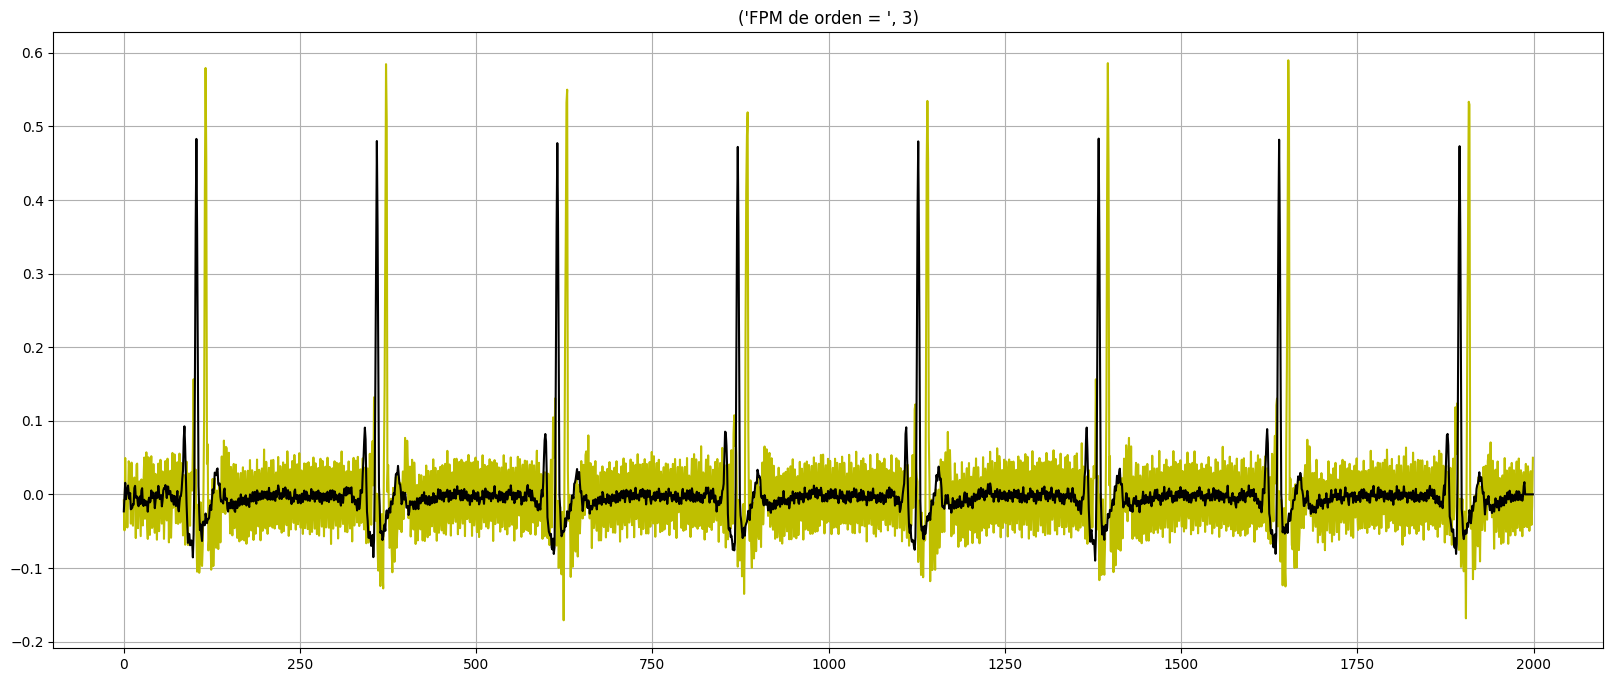

In [17]:
FPM ("/Users/paulaaguirrecarol/Desktop/PDSB 1/ECG10.txt")